In [2]:
import simulator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import make_interp_spline, BSpline
from math import log2
from sklearn import preprocessing

In [3]:
# Actual proteasome correlations
proteasome_corr = pd.read_csv("../data/TPP_proteasome_correlations.csv")
exosome_corr = pd.read_csv("../data/TPP_exosome_correlations.csv")
exosome_corr.head()

,bait,prey,t,corr
0,EXOSC1,EXOSC10,earlyS.median,0.251430
1,EXOSC1,EXOSC4,earlyS.median,-0.218734
2,EXOSC1,EXOSC5,earlyS.median,0.119999
3,EXOSC1,EXOSC6,earlyS.median,0.231901
4,EXOSC1,EXOSC8,earlyS.median,-0.167128


In [4]:
def plot_correlations(corr, bait, prey="all"):
    df_bait = corr[corr["bait"] == bait]

    if prey == "all":
        unique_prey = df_bait["prey"].unique().tolist()
    elif type(prey) is str:
        unique_prey = [prey]
    elif type(prey) is list:
        unique_prey = list(set(prey))

    NUM_PREY = len(unique_prey)
    print(NUM_PREY)

    plt.figure(figsize=(16,10))

    for i in range(NUM_PREY):
        bait_prey = df_bait[df_bait["prey"] == unique_prey[i]]
        plt.plot(
            bait_prey["t"].str.replace(".median", "", regex=False), 
            bait_prey["corr"],
            label = unique_prey[i]
        )

    
    p = "X" if (prey == "all") or (type(prey) is list) else (prey)
    
    title = str(bait) + "-" + str(p) + " Correlations"
    plt.title(title)
    plt.legend()
    plt.show()

4


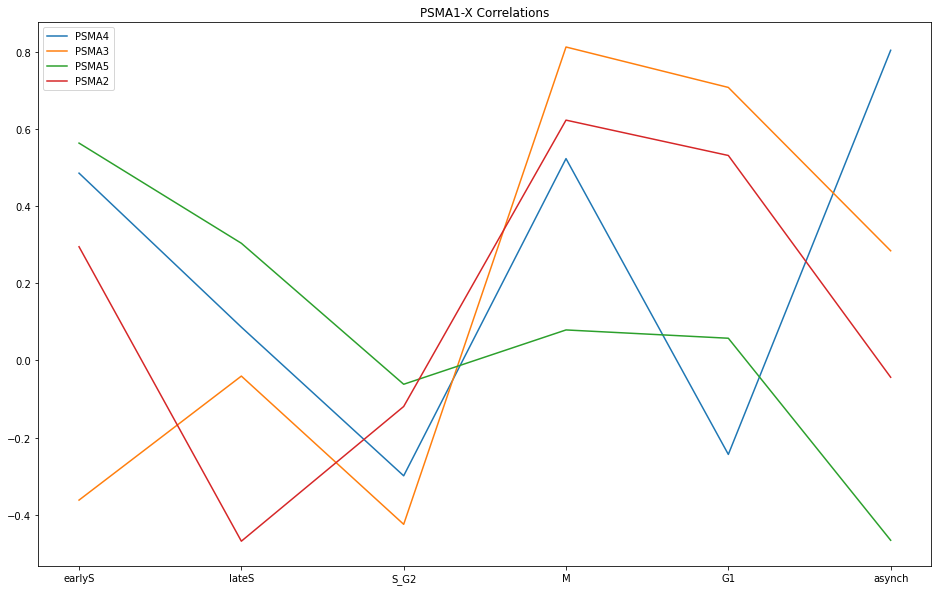

In [5]:
unique_prey = list(proteasome_corr["prey"].unique())
plot_correlations(proteasome_corr, "PSMA1", unique_prey[0:4])

In [6]:
sample_data_raw = pd.read_excel("../data/TPP_sampleData.xlsx", header=0, sheet_name="TableS1_2D-TPP")
sample_data = sample_data_raw[["gene_name", "Temperature", "G1_S.median", "earlyS.median", "lateS.median", "S_G2.median", "M.median", "G1.median"]]
sample_data_cleaned = sample_data.dropna(inplace=False)

In [7]:
# sample_data_cleaned.to_csv("../data/TPP_sampleData_filtered.csv")

In [8]:
sample_data = pd.read_csv("../data/TPP_sampleData_filtered.csv", index_col=0)

(array([  33.,   67.,  126.,  351.,  861.,  989.,  634.,  560.,  518.,
        1252.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

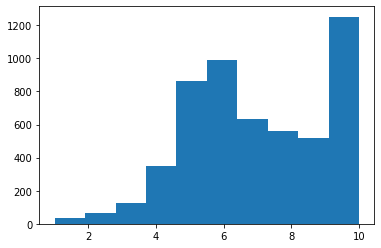

In [9]:
num_temp_readings = []
unique_gene_names = sample_data["gene_name"].unique().tolist()

for name in unique_gene_names:
    num_temp_readings.append(
        len(sample_data[sample_data["gene_name"] == name].dropna())
    )

plt.hist(num_temp_readings)

In [10]:
# plt.hist(num_temp_readings)
sample_data.head()

,gene_name,Temperature,G1_S.median,earlyS.median,lateS.median,S_G2.median,M.median,G1.median
0,A2M,37.0,1.0,0.846904,0.994348,1.053536,0.702568,1.581310
1,A2M,40.4,1.0,0.895550,0.941541,1.068315,0.827830,2.374607
2,A2M,44.0,1.0,0.998815,1.081042,1.175996,0.755730,1.243913
3,A2M,46.9,1.0,1.074115,1.118488,1.141525,1.237420,1.534724
4,A2M,49.8,1.0,0.840277,1.015030,1.074608,0.694423,1.152561


In [11]:
cols = ["gene_name", "G1_S", "lateS", "M", "G1", "lateS", "asynch"]
abundance = pd.DataFrame(columns=cols)
stability = pd.DataFrame(columns=cols)

In [12]:
def calculate_abundance(fc_37, fc_40):
    return (log2(fc_37) + log2(fc_40))/2
    
def calculate_stability(fc, abundance):
    stability = 0
    for i in range(len(fc)):
        stability += (log2(fc[i]) - abundance)
    
    return stability

In [13]:
def populate_abundance_stability(data, phase_names):
    unique_gene_names = data["gene_name"].unique().tolist()
    ab = []
    stab = []

    for name in unique_gene_names:
        gene = sample_data[sample_data["gene_name"] == name].dropna()
        abundance_row = [name, ""]
        stability_row = [name, ""]

        for idx, phase in enumerate(phase_names):
            gp = gene[phase].tolist()

            if len(gp) >= 2:
                try:
                    abundance_row.append(
                        calculate_abundance(
                            gp[0], 
                            gp[1]
                        )
                    )

                    stability_row.append(
                        calculate_stability(
                            gp, 
                            abundance_row[idx + 2]
                        )
                    )
                except KeyError:
                    print("Error!")
                
                
        ab.append(abundance_row)
        stab.append(stability_row)

    abundance_df = pd.DataFrame(ab, columns = data.columns)
    stability_df = pd.DataFrame(stab, columns = data.columns)
    return abundance_df, stability_df

In [14]:
phase_names = ["G1_S.median", "earlyS.median", "lateS.median", "S_G2.median", "M.median", "G1.median"]
ab, stab = populate_abundance_stability(data = sample_data, phase_names = phase_names)

In [15]:
def plot_random_fold_changes():
    plt.figure(figsize=(16,10))

    # Choose random unique gene
    gene = np.random.choice(sample_data["gene_name"].unique())
    df_gene = sample_data[sample_data["gene_name"] == gene].dropna()

    # Go through column corresponding to each phase
    for i in range(6):
        phase = df_gene.columns[i + 2]
        x = df_gene["Temperature"].to_numpy()
        y = df_gene[phase].to_numpy()

        # Spline the lines together
        xnew = np.linspace(x.min(), x.max(), 300) 
        spl = make_interp_spline(x, y, k=3)  # type: BSpline
        y_smooth = spl(xnew)

        # Overlay phase
        plt.plot(xnew, y_smooth, label=phase)

    plt.title("Gene: " + gene)
    plt.legend()
    plt.show()

(array([  3.,  14.,  25.,  43.,  99., 130., 190., 223., 182.,  91.]),
 array([0.42477617, 0.4819397 , 0.53910323, 0.59626675, 0.65343028,
        0.71059381, 0.76775733, 0.82492086, 0.88208438, 0.93924791,
        0.99641144]),
 <BarContainer object of 10 artists>)

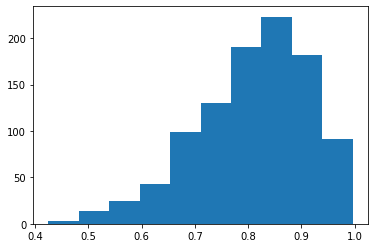

In [16]:
plt.hist([np.random.beta(a=8.83, b=2.12) for _ in range(1000)])

In [17]:
kwargs = {
            "shape":(6,6),                      # (6 time points, 6 values per timepoint)
            "sample_noise_dist": "uniform",     # ~ U[lower bound, upper bound]
            "signal_func_type": "sigmoid",      
            "noise_func_type": "sigmoid",
            "correlation_type": "pearson"
        }

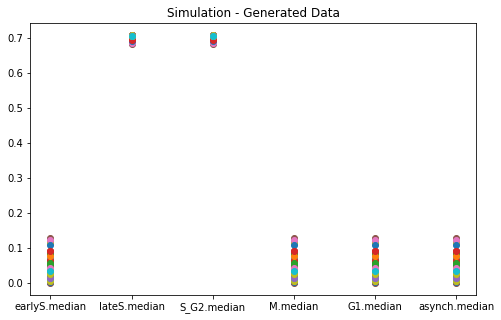

In [18]:
phases = ["earlyS.median", "lateS.median", "S_G2.median", "M.median", "G1.median", "asynch.median"]
corr_generated_data = []

plt.figure(figsize=(8,5))

for i in range(100):
    sim = simulator.Simulator(**kwargs)
    sim.set_timepoints([0,1,1,0,0,0])
    sim.generate_data()
    corr = sim.calculate_correlations()
    corr = np.array(corr)
    corr = (corr + 1).reshape(1,-1)
    normalized_values = preprocessing.normalize(corr)
    plt.scatter(phases, normalized_values)


plt.title("Simulation - Generated Data")
plt.savefig("../figures/simulation_generated_data.png")
plt.show()

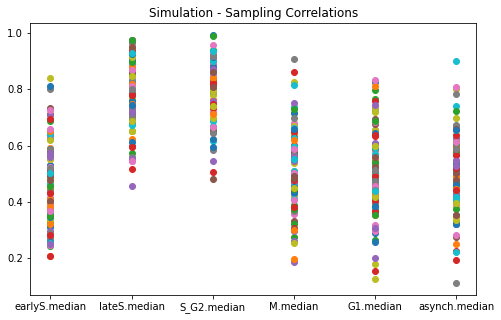

In [19]:
corr_data = []
phases = ["earlyS.median", "lateS.median", "S_G2.median", "M.median", "G1.median", "asynch.median"]

for _ in range(100):
    corr_data.append(sim.sample_correlations())

corr_df = pd.DataFrame(corr_data)

plt.figure(figsize=(8,5))

for i in range(100):
    plt.scatter(phases, corr_df.iloc[i])

plt.title("Simulation - Sampling Correlations")
plt.savefig("../figures/simulation_sampling_correlations.png")
plt.show()

In [22]:
def plot_sample_correlations(bait_name, savefig=False):
    # Temporary fix
    BAIT = bait_name
    
    # Filtering for PSMA1 PSMA2 interactions
    bait = exosome_corr[exosome_corr["bait"] == BAIT]

    unique_prey = bait["prey"].unique().tolist()
    NUM_PREY = len(unique_prey)

    plt.figure(figsize=(8,5))

    for i in range(NUM_PREY):
        bait_prey = bait[bait["prey"] == unique_prey[i]]
        bait_prey.reset_index(inplace=True, drop=True)
        corr = bait_prey["corr"].to_numpy()
        corr = (corr + 1).reshape(1,-1)
        normalized_values = preprocessing.normalize(corr)
        plt.scatter(bait_prey["t"], normalized_values)

    plt.title("All " + BAIT + " Correlations")
    
    if savefig:
        plt.savefig("../figures/all_" + BAIT.lower() + "_correlations.png")

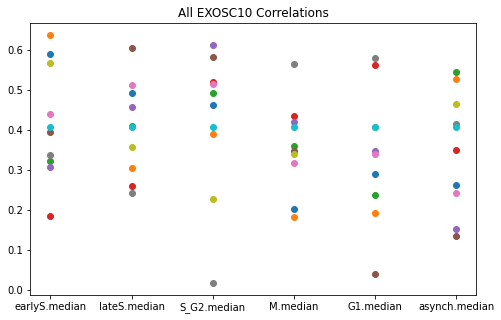

In [25]:
BAIT = "EXOSC10"
plot_sample_correlations(BAIT, savefig=True)